In [1]:
import sys

sys.path.append("../")

## Running the simulations

(All the simulations should be run using scripts) \
This notebook starts by reading the data

In [2]:
# leaks_path = "../data/leaks"
# reports_path = "../data/reports"
# network_path = "../data/Hanoi.inp"

# os.environ["EPANET_HOME"] = "../EPANET/build/bin/runepanet"

# scripts.prepare_files(network_path, leaks_path)
# scripts.run_simulations(leaks_path, reports_path)

## Reading the reports

In [5]:
import pandas as pd
import scripts
import os


def extract_node_id(path: str) -> int:
    normpath = os.path.normpath(path)
    filename = normpath.split("/")[-1]
    return int(filename.split("_")[0])

In [6]:
report_dir_path = "../data/reports"
filenames = os.listdir(report_dir_path)

report_paths = [os.path.join(report_dir_path, filename) for filename in filenames if not filename.startswith("baseline")]
reports = [(scripts.read_report(path), extract_node_id(path)) for path in report_paths]

baseline_report = scripts.read_report(os.path.join(report_dir_path, "baseline_1.rpt"))

# Baseline report is the report from the run that was run without the leakage

In [8]:
for i in range(1, len(baseline_report)):
    print((baseline_report[i-1] == baseline_report[i]).all())

pressure    True
dtype: bool
pressure    True
dtype: bool
pressure    True
dtype: bool


In [9]:
def report_to_pandas(report: list[pd.DataFrame], leakage_node: int) -> pd.DataFrame:

    training_example = []
    for i, pressure_measure in enumerate(report):
        pressure_measure = pressure_measure.T.reset_index(drop=True)
        pressure_measure.columns.name = None

        pressure_measure["ts"] = i
        pressure_measure["leakage_node"] = leakage_node

        training_example.append(pressure_measure)

    row_df = pd.concat(training_example)
    return row_df


def transform_whole_dataset(reports: list[tuple[list[pd.DataFrame], int]]) -> pd.DataFrame:
    report_dataframes = []

    for report in reports:
        report_dataframes.append(report_to_pandas(*report))

    df = pd.concat(report_dataframes).reset_index(drop=True)
    return df

In [10]:
df = transform_whole_dataset(reports)
df

,2,3,4,5,6,7,8,9,10,11,...,26,27,28,29,30,31,32,1,ts,leakage_node
0,67.01,29.82,25.39,19.90,14.15,12.83,11.28,10.07,9.19,7.63,...,1.92,1.26,4.99,0.69,0.07,0.41,1.42,-0.0,0,19
1,67.01,29.82,25.39,19.90,14.15,12.83,11.28,10.07,9.19,7.63,...,1.92,1.26,4.99,0.69,0.07,0.41,1.42,-0.0,1,19
2,66.98,29.45,24.38,18.09,11.41,9.83,7.90,6.33,5.16,2.43,...,1.09,0.09,4.73,0.57,0.05,0.30,1.12,-0.0,0,12
3,66.98,29.45,24.38,18.09,11.41,9.83,7.90,6.33,5.16,2.43,...,1.09,0.09,4.73,0.57,0.05,0.30,1.12,-0.0,1,12
4,66.71,25.62,18.93,13.95,8.81,7.64,6.33,5.33,4.63,3.39,...,0.37,0.03,3.33,0.10,0.01,0.07,0.40,-0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,66.67,25.08,18.13,9.48,0.02,0.01,0.00,0.00,0.00,0.00,...,0.29,0.02,3.17,0.09,0.01,0.06,0.33,-0.0,1,6
752,67.01,29.88,25.42,19.91,14.13,12.79,11.24,10.01,9.12,7.56,...,0.00,0.03,3.63,0.13,0.00,0.00,0.00,-0.0,0,25
753,67.01,29.88,25.42,19.91,14.13,12.79,11.24,10.01,9.12,7.56,...,0.00,0.03,3.63,0.13,0.00,0.00,0.00,-0.0,1,25
754,67.01,29.88,25.42,19.91,14.13,12.79,11.24,10.01,9.12,7.56,...,0.00,0.03,3.63,0.13,0.00,0.00,0.00,-0.0,2,25


In [15]:
baseline_pressures = report_to_pandas(baseline_report, -1)
baseline_pressures = baseline_pressures.iloc[[0]].drop(columns=["ts", "leakage_node"]).to_numpy()
ts, leakage_node = df["ts"], df["leakage_node"]
pressures = df.drop(columns=["ts", "leakage_node"]).to_numpy()

pressures = pressures - baseline_pressures # Following the the method from the paper, we subtract the baseline pressures from the measured pressures

## Reading the graph

In [16]:
from epyt import epanet

input_file = "../data/Hanoi.inp"
G = epanet(input_file)

EPANET version 20200 loaded (EPyT version v1.2.1 - Last Update: 09/01/2024).
Input File Hanoi.inp loaded successfully.



Computing distances between every node using Floyd-Warshall algorithm. Those distances are needed in evaluation function in Simulated Annealing.

In [17]:
import numba
import numpy as np

@numba.jit(nopython=True)
def triple_loop(dist: np.ndarray, n: int) -> np.ndarray:
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    return dist


def floyd_warshall(adj_matrix: np.ndarray, undirected: bool = True) -> np.ndarray:
    n = adj_matrix.shape[0]
    if undirected:
        adj_matrix = np.maximum(adj_matrix, adj_matrix.T)
        
    dist = np.full_like(adj_matrix, float(n + 1))
    dist[adj_matrix > 0] = 1.0
    np.fill_diagonal(dist, 0.0)

    dist = triple_loop(dist, n)
    return dist


def matrix_to_adj_list(matrix: np.ndarray, undirected: bool = True) -> list[set[int]]:
    n = matrix.shape[0]
    if undirected:
        matrix = np.maximum(matrix, matrix.T)

    adj_list = [set() for _ in range(n)]
    for i, row in enumerate(matrix):
        for neighbor, connected in enumerate(row):
            if connected > 0:
                adj_list[i].add(neighbor)
                adj_list[neighbor].add(i)

    return adj_list


class Network:
    def __init__(self, G: epanet):
        self.G = G

        self.adj_matrix = G.getAdjacencyMatrix()
        self.adj_list = matrix_to_adj_list(self.adj_matrix, undirected=True)
        self.distances = floyd_warshall(self.adj_matrix, undirected=True)

        self.node_ids = G.NodeNameID
        self.node_indexes = list(map(lambda x: x - 1, G.NodeIndex))
        self.node_id_to_position_mapping = dict(zip(G.NodeNameID, self.node_indexes))

    def plot_with_ids(self):
        self.G.plot(nodesID=self.node_ids, fontsize=3)

    def plot_with_indexes(self):
        self.G.plot(nodesindex=list(map(lambda x: x + 1, self.node_indexes)), fontsize=3)

    def neighbor_array(self, vertex: int) -> np.ndarray:
        return np.array(list(self.adj_list[vertex]))

    def map_node_ids(self, ids: np.ndarray) -> np.ndarray:
        ids = list(map(str, ids))
        return np.array(list(map(self.node_id_to_position_mapping.get, ids)))

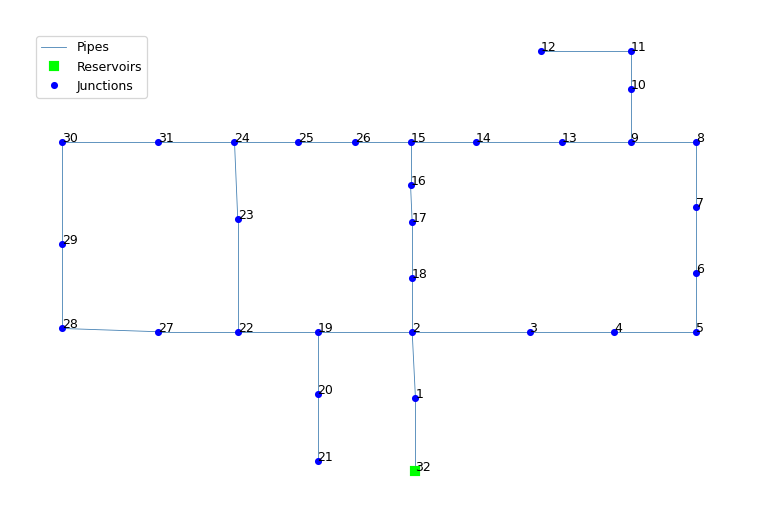

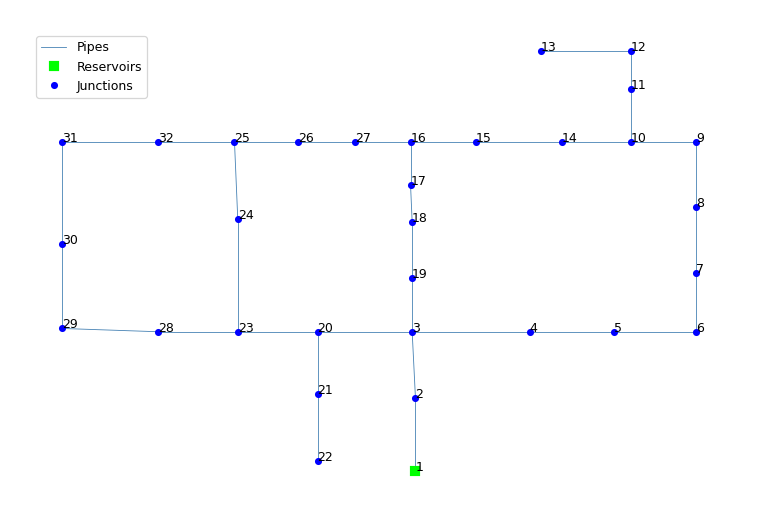

In [18]:
network = Network(G)
network.plot_with_indexes()
network.plot_with_ids()

## Simulated Annealing

Genrating random starting point

In [19]:
def random_solution(vertices: np.ndarray, m: int) -> np.ndarray:
    return np.random.permutation(vertices)[:m]

vertices = np.array(network.node_indexes)
solution = random_solution(vertices, 3)

Data split, training dataset is used to fit the KNN-classifier. The prediction on the test dataset is used in the evaluation function.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

leakage_node_mapped = network.map_node_ids(leakage_node)
train_pressures, test_pressures, train_labels, test_labels = train_test_split(pressures, leakage_node_mapped, test_size=0.5, stratify=leakage_node)

Function for the evaluation of the candidate solution

In [28]:
def evaluate_solution(
        vertices_subset: np.ndarray, 
        network: Network,
        train_pressures: np.ndarray,
        train_labels: np.ndarray,
        test_pressures: np.ndarray,
        test_labels: np.ndarray,
        d_max: float = 5
    ) -> float:

    train_subset = train_pressures[:, vertices_subset]
    test_subset = test_pressures[:, vertices_subset]

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_subset, train_labels)

    pred_label = knn.predict(test_subset)

    dists = network.distances[pred_label, test_labels] / d_max
    dists[dists >= 1.0] = 1.0 
    loss = dists.sum() / pred_label.shape[0]

    return loss


solution = random_solution(vertices, 4)
print(solution)
evaluate_solution(solution, network, train_pressures, train_labels, test_pressures, test_labels)

[ 1 14 10 21]


np.float64(0.04497354497354497)

Neighbor generating function for the annealing.

In [29]:
def generate_neighbor(vertex_subset: np.ndarray, network: Network) -> np.ndarray:

    count = 0
    while count < 100:
        vertex_to_swap = np.random.choice(vertex_subset)
        neighboring_vertex = np.random.choice(network.neighbor_array(vertex_to_swap))
        if neighboring_vertex not in vertex_subset:
            break
        count += 1

    new_vertices = vertex_subset.copy()
    new_vertices[new_vertices == vertex_to_swap] = neighboring_vertex

    return new_vertices

In [30]:
generate_neighbor(solution, network)

array([ 2, 14, 10, 21])

### Annealing

In [33]:
from typing import Callable

def f(delta, T):
    return np.exp(-delta/T)

def annealing(
    vertices: np.ndarray,
    network: Network,
    train_pressures: np.ndarray,
    train_labels: np.ndarray,
    test_pressures: np.ndarray,
    test_labels: np.ndarray,
    neighbor_fun: Callable[[np.ndarray, Network], np.ndarray] = generate_neighbor,

    steps: int = 1000, 
    T0: int = 50, 
    alpha: float = 0.99, 
    no_of_iter: int = 40, 
) -> None:
    
    solution = random_solution(vertices, 5)
    cur_energy = evaluate_solution(
        solution, network, 
        train_pressures, train_labels,
        test_pressures, test_labels
    )

    energy_states = [cur_energy]
    T = T0
    temperature = [T0]

    for i in range(steps):
        print(f"Step {i}")
        for _ in range(no_of_iter):
            new_solution = neighbor_fun(solution, network)
            next_energy = evaluate_solution(
                new_solution, network,
                train_pressures, train_labels,
                test_pressures, test_labels
            )

            if next_energy < cur_energy:
                solution = new_solution
                cur_energy = next_energy
            else:
                probability = f(next_energy - cur_energy, T)
                if probability > np.random.uniform(0, 1):
                    solution = new_solution
                    cur_energy = next_energy

        T *= alpha
        temperature.append(T)
        energy_states.append(cur_energy)

    return energy_states, temperature

In [34]:
E, T = annealing(vertices, network, train_pressures, train_labels, test_pressures, test_labels)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Ste

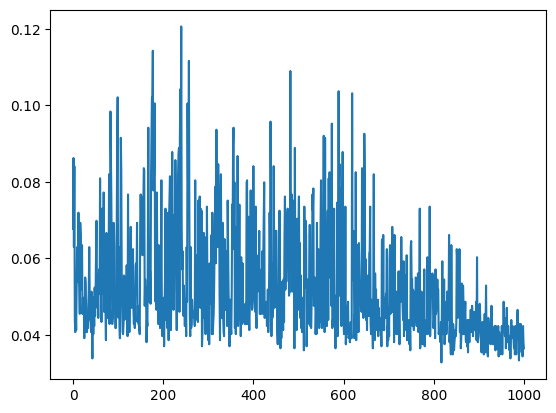

In [35]:
import matplotlib.pyplot as plt

plt.rcdefaults()
plt.plot(E)
plt.show()

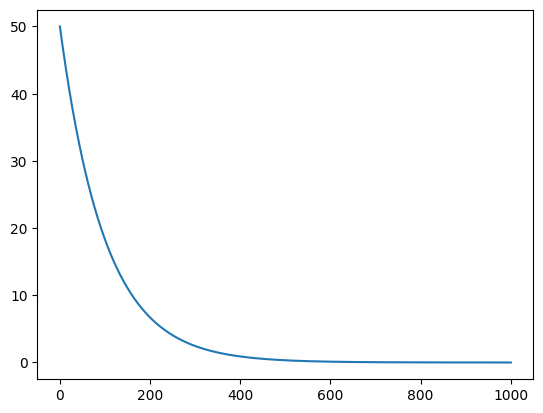

In [36]:
plt.plot(T)
plt.show()